## Offline RL

In [1]:
# HIDDEN
import gym
import numpy as np

#### Is this realistic?

- So far we've built a simulation of user behavior
- In some applications, we may be able to build accurate simulations:
  - physics simulations (e.g. robots)
  - games
  - economic/financial simulations?
- However, for user behavior, this is hard

#### Is this realistic? 

- Best would be to deploy RL live, but not practical
- Another possibility: learn from user data?
- We can do this with **offline reinforcement learning**

#### Offline RL

- What is offline RL?
- Recall our RL loop:

![](img/RL-loop-3.png)

#### Offline RL

- In offline RL we don't have an environment to interact with in a feedback loop:

![](img/offline-RL-loop.png)

This historic data was generated by some other, unknown policy/policies.

Notes:

Could be generate by real users, or by a different source (random, or RL agent!)

#### Challenge of offline RL

- Can't answer "what if" questions
- We can only see the results of actions attempted in the dataset

Notes:

Perhaps this makes us appreciate how valuable/awesome it is to actually have an env available, which we have had for all the rest of the course. It allows us to try anything with no cost except computational cost (assuming it's a simulator, not a real world environment). 

In [2]:
# HIDDEN
# #### Types of offline RL

# Two main categories:

# 1. No rewards available: try to _imitate_ historic policy

# This boils down to supervised learning of observations -> actions
 
# 2. Rewards available: try to _improve upon_ historic policy

# Use rewards to improve policy. This is what we want, ideally!

#### Recommender dataset

- Let's explore an offline dataset that we can learn from.
- We'll need a bit of code to read all the JSON objects in the file:

Notes:

The file is in the format that RLlib learns from.

In [3]:
import json

json_dataset_file = "data/recommender_offline.json"

rollouts = []
with open(json_dataset_file, "r") as f:
    for line in f:
        data = json.loads(line)
        rollouts.append(data)

In [4]:
len(rollouts)

50

We have 50 "rollouts" of data.

#### Recommender dataset

Each rollout is a dict containing info about the time step:

In [5]:
from ray.rllib.utils.compression import unpack, pack

obs = unpack(rollouts[0]["obs"])
obs.shape

(200, 2)

- We have 200 time steps worth of data in each rollout
- Each is an observation:

Notes:

This number 200 is set by the "rollout_fragment_length" algorithm config parameter.

In [6]:
obs[:3]

array([[0.6545137 , 0.29728338],
       [0.5238871 , 0.5144319 ],
       [0.6741674 , 0.10163702]], dtype=float32)

- Here are the first 3 observations
- We can see `num_candidates` was set as 2

#### Recommender dataset

We can also look at the first 3 actions, rewards, dones:

In [7]:
rollouts[0]["actions"][:3]

[0, 0, 1]

In [8]:
rollouts[0]["rewards"][:3]

[0.6545137166976929, 0.3524414300918579, 0.05838315561413765]

In [9]:
rollouts[0]["dones"][:3]

[False, False, False]

Notes:

So, first the agent saw the observation [0.65, 0.297] from the previous slide, then it took action 0, got a reward of 0.65, and the episode was not done.

There is more information stored in the dataset than just the above, but these are the key points.

#### Offline RL training

- Lots of info on offline RL with RLlib [here](https://docs.ray.io/en/latest/rllib/rllib-offline.html)
- First we need our trainer config.

In [10]:
num_candidates = 2

offline_trainer_config = {
    # These should look familiar:
    "framework"             : "torch",
    "create_env_on_driver"  : True,
    "seed"                  : 0,
    "model"                 : {
        "fcnet_hiddens"     : [64, 64]
    },
    
    # These are new for offline RL:
    "input": [json_dataset_file],
    "observation_space": gym.spaces.Box(low=0, high=1, shape=(num_candidates,)),
    "action_space": gym.spaces.Discrete(num_candidates),
}

Notes:

- The config items on the top should look familiar. On the second half, things are a bit different:
  - We need to give it the path to the dataset file
  - Because there is no env, we need to manually specify the observation and action spaces
- We don't have an environment config because there is no environment!

#### Training

- For offline RL we can't use `PPO`.
- We'll use the `MARWIL` algorithm that is included with RLlib.

In [11]:
from ray.rllib.agents.marwil import MARWILTrainer

In [12]:
trainer = MARWILTrainer(config=offline_trainer_config)

In [13]:
for i in range(10):
    trainer.train()

Ok, we apparently did some training. _How do we evaluate without a simulator?_

#### Offline evaluation

In [18]:
trainer.evaluate()["evaluation"]["off_policy_estimator"]["wis"]

{'V_prev': 16.325394203305805,
 'V_step_WIS': 22.619529016166922,
 'V_gain_est': 1.3817053996773574}

- Recall that we achieved rewards of >25 last time
- But this may be the best we can do with the given data

Notes:

- V_prev shows the estimated episode reward of the historical policy
- V_step_WIS shows the estimate episode reward of the new policy
- V_gain_est is the ratio of these two quantities; here we see an estimated improvement of 38%.

#### Ground-truth evaluation

- We can also evaluate the algorithm using our env simulator:

In [22]:
# HIDDEN
from envs import BasicRecommender

env_config = {
    "num_candidates" : 2,
    "alpha"          : 0.5,
    "seed"           : 42
}

In [27]:
env = BasicRecommender(env_config)

def get_episode_reward(env, trainer):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = trainer.compute_single_action(obs)
        obs, reward, done, _ = env.step(action)
        total_reward += reward
    return total_reward

In [28]:
np.mean([get_episode_reward(env, trainer) for i in range(100)])

25.490920840544344

Notes:

In a real offline RL situation where all we had is the user data, we wouldn't have an accurate simulator available. We're just using it here as a sanity check to see if our MARWIL algorithm learned effectively. 

It is also possible to have RLlib do this for you by setting `"input_evaluation": ["simulation"]` and providing the env. However, then we have to trust it not to use the env for learning!

#### Let's apply what we learned!

## Example of offline RL
<!-- multiple choice -->

- [ ] Teaching an AI to play chess by having it play against other AIs repeatedly.
- [x] Teaching an AI to play chess based on past games by professional chess players.

## Does offline data help?
<!-- multiple choice -->

Imagine you have an env that perfectly represents your environment; for example, maybe you are training an AI to play a single-player game like [Atari Breakout](https://en.wikipedia.org/wiki/Breakout_(video_game)). In addition to the simulator, you also have some offline data available. Though not discussed in the above slides, it is possible to mix a simulator with offline data to jointly train an agent using RL (see [here](https://docs.ray.io/en/latest/rllib/rllib-offline.html#mixing-simulation-and-offline-data)). If you already have a perfect simulator, could offline data provide any additional utility, if combined with the simulator during training?

#### Best policy after training

Choose the correct statement regarding finding the best policy after unlimited training. You can assume you have a 'perfect' RL algorithm, meaning it can represent any policy and is able to optimize any function.

- [x] With a 'perfect' RL algorithm and enough compute time, there is no benefit to using the historical data because the simulator contains everything there is to know about the environment.
- [ ] With a 'perfect' RL algorithm and unlimited compute time, the historical data may help you find a better policy than only using the simulator. | With a 'perfect' RL algorithm, you should eventually find the optimal policy. This is like having infinite data, infinite compute time, an arbitrarily complex model, and a perfect optimization method.

#### Training speed

Choose the correct statement regarding finding the best policy after a bit of training. You can assume you have a 'perfect' RL algorithm, meaning it can represent any policy and is able to optimize any function.

- [ ] With a 'perfect' RL algorithm but only a bit of compute time, there is no benefit to using the historical data because the simulator contains everything there is to know about the environment. | What if the historical data was generated using the *optimal* policy?
- [x] With a 'perfect' RL algorithm but only a bit of compute time, the historical data may help you find a better policy than only using the simulator. | If the historical data was generated using a very good policy, you could learn from it quickly.

## Historical data policy
<!-- multiple choice -->

Offline RL relies on data generated by some policy interacting with the environment. Which of the following is **NOT** a desirable property of this dataset / historical policy?
 
- [x] The environment and the historical policy are both deterministic. | In this case, we would only explore one trajectory through the environment. 
- [ ] The dataset contains a large number of episodes.
- [ ] The historical policy explores a variety of states in the environment.
- [ ] The historical policy achieves high reward in some episodes.   

## Coding
<!-- coding exercise -->

In this exercise we'll tackle the famous [Cartpole benchmark problem](https://www.gymlibrary.ml/environments/classic_control/cart_pole/) that is bundled with the `gym` library. The goal is to keep the inverted pendulum from falling over by applying force, either left or right, at each time step. 

We will train the agent using offline data contained in a file `cartpolev1_offline.json` that is read in by the code.

We will _evaluate_ the agent using the off-policy evaluation discussed in the slides, _but also_ using the real Cartpole simulator. In reality, if we were using offline RL we probably wouldn't have access to the real simulator, but we're including it here so that we can do ground-truth evaluation of our agent.

Fill in the missing code. Then, run the code and answer the multiple-choice question below.

/Users/mike/miniconda3/envs/rl-course-dev-2/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
2022-07-17 09:09:59,570	WARNING rollout_worker.py:664 -- Requested 'simulation' input evaluation method: will discard all sampler outputs and keep only metrics.


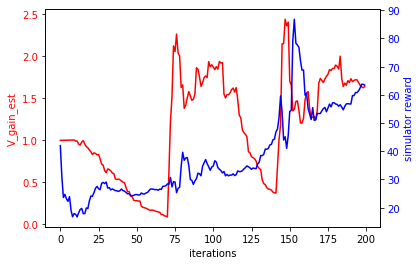

In [2]:
# EXERCISE
import gym
import numpy as np
import matplotlib.pyplot as plt
from ray.rllib.agents.marwil import MARWILTrainer

offline_trainer_config = {
    # These should look familiar:
    "framework"             : "torch",
    "create_env_on_driver"  : True,
    "seed"                  : 0,
    "model"                 : {
        "fcnet_hiddens"     : [64, 64]
    },
    
    # These are new for offline RL:
    ____: ["data/cartpolev1_offline.json"],
    "observation_space": gym.spaces.Box(low=____, 
                                        high=np.array([4.8,  np.inf,  0.42,  np.inf])),
    "action_space": gym.spaces.Discrete(2),
    "input_evaluation" : ["simulation", "is", "wis"],
    "env" : "CartPole-v1" # for evaluation only
}

trainer = MARWILTrainer(config=____)

# Training (and storing results)
results_off = []
results_sim = []
for i in range(200):
    r = trainer.____()
    results_off.append(r["off_policy_estimator"]["wis"]['V_gain_est'])
    results_sim.append(r["episode_reward_mean"])

# Plotting code (you can ignore)
fig, ax1 = plt.subplots() 
ax1.set_xlabel('iterations') 
ax1.set_ylabel('V_gain_est', color='r') 
ax1.plot(results_off, color='r') 
ax1.tick_params(axis ='y', labelcolor='red') 
ax2 = ax1.twinx() 
ax2.set_ylabel('simulator reward', color='b') 
ax2.plot(results_sim, color='b') 
ax2.tick_params(axis ='y', labelcolor='blue') 

trainer.stop()

In [ ]:
# SOLUTION
import gym
import numpy as np
import matplotlib.pyplot as plt
from ray.rllib.agents.marwil import MARWILTrainer

offline_trainer_config = {
    # These should look familiar:
    "framework"             : "torch",
    "create_env_on_driver"  : True,
    "seed"                  : 0,
    "model"                 : {
        "fcnet_hiddens"     : [64, 64]
    },
    
    # These are new for offline RL:
    "input": ["data/cartpolev1_offline.json"],
    "observation_space": gym.spaces.Box(low=np.array([-4.8, -np.inf, -0.42, -np.inf]), 
                                        high=np.array([4.8,  np.inf,  0.42,  np.inf])),
    "action_space": gym.spaces.Discrete(2),
    "input_evaluation" : ["simulation", "is", "wis"],
    "env" : "CartPole-v1" # for evaluation only
}

trainer = MARWILTrainer(config=offline_trainer_config)

# Training (and storing results)
results_off = []
results_sim = []
for i in range(200):
    r = trainer.train()
    results_off.append(r["off_policy_estimator"]["wis"]['V_gain_est'])
    results_sim.append(r["episode_reward_mean"])

# Plotting code (you can ignore)
fig, ax1 = plt.subplots() 
ax1.set_xlabel('iterations') 
ax1.set_ylabel('V_gain_est', color='r') 
ax1.plot(results_off, color='r') 
ax1.tick_params(axis ='y', labelcolor='red') 
ax2 = ax1.twinx() 
ax2.set_ylabel('simulator reward', color='b') 
ax2.plot(results_sim, color='b') 
ax2.tick_params(axis ='y', labelcolor='blue') 

trainer.stop()

#### What happens during the training with offline RL?

- [x] The agent 'thinks' it is improving, and in fact it really is improving, according to the simulator.
- [ ] The agent 'thinks' it is improving, but it actually isn't learning, according to the simulator. | Take a look at the blue line on the graph; is the reward improving?
- [ ] The agent 'thinks' it isn't learning, but in fact it really is improving, according to the simulator. | Take a look at the red line on the graph; is the reward metric improving?
- [ ] The agent 'thinks' it isn't learning, and indeed it isn't learning, according to the simulator. | Take a look at the red line on the graph; is the reward metric improving?